In [1]:
import ast
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
# do not truncate the dataframe column width
pd.options.display.max_colwidth = None
pd.options.display.max_columns = None

sys.path.append('F:/repo/gpsbeam')

from src.data.dataprep import DataPrep
from src.config.data_config import DataConfig
from src.data.dataplot import DataPlot

replace_dict = {
    'unit2to1_vector':'ue_bs_vector',
    'unit2_loc_minmax_norm':'ue_normalized_lat_lon',
    'unit1_beam_idx_64':'beam_vector'
}

def combined_metric(row):
    loss_db = np.mean(row['pred0_top1_mean_power_loss_db'] + row['pred1_top1_mean_power_loss_db']\
             + row['pred2_top1_mean_power_loss_db'] + row['pred3_top1_mean_power_loss_db'])
    accuracy = np.mean(row['pred0_top1_test_acc_percent'] + row['pred1_top1_test_acc_percent']\
                      + row['pred2_top1_test_acc_percent'] + row['pred3_top1_test_acc_percent']) / 100
    invert_loss_db = 1/loss_db
    return (invert_loss_db * 0.5) + (accuracy * 0.5)

def df_apply_combined_metric(df):
    key = 'combined_loss_db_and_acc'
    df[key] = df.apply(combined_metric, axis=1)
    df = df.sort_values(by=key, ascending=False)
    return df

def compare_power_loss(fname, df, variable, title, 
                       chart_type='bar', fig_size=(12, 8), 
                       fontsize=10, lower_y=0,
                       display_title=True, y_max_multiplier=1.2,
                       bar_width=0.35, axis_fontsize=10):  # Added axis_fontsize parameter
    # Set up the plot
    fig, ax = plt.subplots(figsize=fig_size)  # Increased figure size

    # Define the columns to plot
    selected_columns = ['pred0_top1_mean_power_loss_db', 'pred1_top1_mean_power_loss_db', 
                              'pred2_top1_mean_power_loss_db', 'pred3_top1_mean_power_loss_db']
    

    if chart_type == 'bar':
        # Set the positions of the bars
        r = range(len(selected_columns))

        # Adjust the plot area to make room for the legend
        plt.subplots_adjust(top=0.5)  # Reduce top margin to make room for legend

        # Plot bars for each variable value
        max_value = 0
        for i, var_value in enumerate(df[variable]):
            values = df.loc[df[variable] == var_value, selected_columns].values[0]
            ax.bar([x + i*bar_width for x in r], values, width=bar_width, 
                label=str(var_value))
            max_value = max(max_value, max(values))

        # Add value labels on top of each bar with adjusted position
        for i, var_value in enumerate(df[variable]):
            values = df.loc[df[variable] == var_value, selected_columns].values[0]
            for j, v in enumerate(values):
                ax.text(j + i*bar_width, v, f'{v:.2f}', ha='center', va='bottom', fontsize=fontsize)

        ax.set_xticks([x + bar_width*(len(df[variable])-1)/2 for x in r])
        ax.set_xticklabels(['\n'.join(word.capitalize() for word in i.split('_')[:2]).replace('Pred0', 
                                        'Current Beam').replace('Pred', 'Future Beam-')+ ' Prediction' for i in selected_columns],
                                        fontsize=axis_fontsize)

        # Set y-axis limit to make room for legend
        ax.set_ylim(lower_y, max_value * y_max_multiplier)  # Use y_max_multiplier parameter

        # Move legend above the plot
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize=axis_fontsize)
        ax.set_xlabel('Model Output', fontsize=axis_fontsize)

    elif chart_type == 'line':
        for i, column in enumerate(selected_columns):
            label = 'Current Beam' if i == 0 else f'Future Beam {i}'
            label += '\nTop1 Prediction'
            ax.plot(df[variable], df[column], marker='o', label=label)
        
        # Get the maximum y-value
        max_y = max(df[column].max() for column in selected_columns)
        
        # Set the top y-axis limit using y_max_multiplier parameter
        ax.set_ylim(lower_y, max_y * y_max_multiplier)
        
        # Set x-axis ticks to represent actual values
        ax.set_xticks(df[variable])
        ax.set_xticklabels(df[variable], fontsize=axis_fontsize)
        
        # Move legend above the plot
        ax.legend(loc='upper right', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=axis_fontsize)
        ax.set_xlabel(variable, fontsize=axis_fontsize)

    # Customize the plot
    
    ax.set_ylabel('Mean Power Loss (dB)', fontsize=axis_fontsize)
    if display_title:
        ax.set_title(f'Comparison of Power Loss between {title}', fontsize=axis_fontsize)
    ax.legend(loc='best', fontsize=axis_fontsize)

    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=axis_fontsize)

    plt.tight_layout()
    
    # Save figures
    fname = fname.split('/')[:-1] if '/' in fname else fname.split('\\')[:-1]
    fname = '/'.join(fname)
    
    # Save the plot data to CSV
    plot_data = df[selected_columns].copy()
    plot_data[variable] = df[variable]
    plot_data.to_csv(f'{fname}/power_loss_{variable}_data.csv', index=False)
    print(f"Saving plot data to {fname}/power_loss_{variable}_data.csv")
    
    plt.savefig(f'{fname}/power_loss_{variable}.pdf')
    plt.savefig(f'{fname}/power_loss_{variable}.png')
    plt.show()
    
    

def compare_acc(fname, df, variable, title, 
                chart_type='bar', fig_size=(12, 8), 
                fontsize=10, lower_y=0,
                display_title=True, y_max_multiplier=1.2,
                bar_width=0.35, axis_fontsize=10):  # Added axis_fontsize parameter
    # Set up the plot
    fig, ax = plt.subplots(figsize=fig_size)  # Increased figure size

    # Define the columns to plot
    selected_columns = ['pred0_top1_test_acc_percent',
                            'pred1_top1_test_acc_percent',
                            'pred2_top1_test_acc_percent',
                            'pred3_top1_test_acc_percent',]
   
    if chart_type == 'bar':
        # Set the width of each bar and the positions of the bars
        r = range(len(selected_columns))

        # Adjust the plot area to make room for the legend
        plt.subplots_adjust(top=0.5)  # Reduce top margin to make room for legend

        # Plot bars for each variable value
        max_value = 0
        for i, var_value in enumerate(df[variable]):
            values = df.loc[df[variable] == var_value, selected_columns].values[0]
            ax.bar([x + i*bar_width for x in r], values, width=bar_width, 
                label=str(var_value))
            max_value = max(max_value, max(values))

        # Add value labels on top of each bar with adjusted position
        for i, var_value in enumerate(df[variable]):
            values = df.loc[df[variable] == var_value, selected_columns].values[0]
            for j, v in enumerate(values):
                ax.text(j + i*bar_width, v, f'{v:.2f}', ha='center', va='bottom', fontsize=fontsize)

        ax.set_xticks([x + bar_width*(len(df[variable])-1)/2 for x in r])
        
        ax.set_xticklabels(['\n'.join(word.capitalize() for word in i.split('_')[:2]).replace('Pred0', 
                                        'Current Beam').replace('Pred', 'Future Beam-')+ 'Prediction' for i in selected_columns],
                                        fontsize=axis_fontsize)

        # Set y-axis limit to make room for legend
        ax.set_ylim(lower_y, max_value * y_max_multiplier)

        # Move legend above the plot
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize=axis_fontsize)
        ax.set_xlabel('Model Output', fontsize=axis_fontsize)

    elif chart_type == 'line':
        for i, column in enumerate(selected_columns):
            label = 'Current Beam' if i == 0 else f'Future Beam {i}'
            label += '\nTop1 Prediction'
            ax.plot(df[variable], df[column], marker='o', label=label)

        # Get the maximum y-value
        max_y = max(df[column].max() for column in selected_columns)
        # print(max_y)

        # Set x-axis ticks to represent actual values
        ax.set_xticks(df[variable])
        ax.set_xticklabels(df[variable], fontsize=axis_fontsize)
        
        # Set the top y-axis limit to be y_max_multiplier times higher than the maximum value
        ax.set_ylim(lower_y, max_y * y_max_multiplier)
        
        # Move legend above the plot
        # ax.legend(loc='upper right', bbox_to_anchor=(0.5, 1.15), ncol=2)
        ax.set_xlabel(variable, fontsize=axis_fontsize)

    # Customize the plot
    
    ax.set_ylabel('Accuracy (%)', fontsize=axis_fontsize)
    if display_title:
        ax.set_title(f'Comparison of Top1 Accuracy between {title}', fontsize=axis_fontsize)
    ax.legend(loc='best', fontsize=axis_fontsize)

    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=axis_fontsize)

    plt.tight_layout()
    
    # Save figures
    fname = fname.split('/')[:-1] if '/' in fname else fname.split('\\')[:-1]
    fname = '/'.join(fname)
    plt.savefig(f'{fname}/acc_{variable}.pdf')
    plt.savefig(f'{fname}/acc_{variable}.png')
    
    # Save the dataframe to CSV
    df.to_csv(f'{fname}/acc_{variable}_data.csv', index=False)
    print(f"Saving dataframe to {fname}/acc_{variable}_data.csv")
    
    plt.show()

def compare_model_size(fname, df, variable, 
                       title, fig_size=(12, 8), 
                       fontsize=10, display_title=True):
    # Set up the plot
    fig, ax = plt.subplots(figsize=fig_size)  # Increased figure size

    selected_columns = ['model_size_MiB']
    r = range(len(df[variable]))

    # Plot horizontal bars
    for i, column in enumerate(selected_columns):
        ax.barh(r, df[column])

    # Add value labels
    for i, column in enumerate(selected_columns):
        for j, v in enumerate(df[column]):
            ax.text(v, j, f'{v:.2f}', ha='left', va='center', fontsize=fontsize)

    ax.set_yticks(r)
    ax.set_yticklabels(df[variable])
    
    # Customize the plot
    ax.set_xlabel('Model Size (MB)')
    ax.set_ylabel(variable)
    if display_title:
        ax.set_title(f'Comparison of Model Size between {title}')
    # ax.legend(loc='best')

    plt.tight_layout()
    
    # Save figures
    fname = fname.split('/')[:-1] if '/' in fname else fname.split('\\')[:-1]
    fname = '/'.join(fname)
    print(f'{fname}/model_size_{variable}.pdf')
    plt.savefig(f'{fname}/model_size_{variable}.pdf')
    plt.savefig(f'{fname}/model_size_{variable}.png')
    plt.show()
    
    


# Dataset Splitting Method Variation

In [2]:
fname = r'F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_spliting_method_20052025_153444\model_recap\exp_test_result_recap.csv'
df = pd.read_csv(fname)
# df = df_apply_combined_metric(df)
df

,splitting_method,num_classes,model_input_column_list,scenario_num,avg_loss,model_size_MiB,pred0_top1_mean_power_loss_db,pred1_top1_mean_power_loss_db,pred2_top1_mean_power_loss_db,pred3_top1_mean_power_loss_db,pred0_top1_n_beams_for_80pct_conf,pred1_top1_n_beams_for_80pct_conf,pred2_top1_n_beams_for_80pct_conf,pred3_top1_n_beams_for_80pct_conf,pred0_top1_overhead_saving_for_80pct_conf,pred1_top1_overhead_saving_for_80pct_conf,pred2_top1_overhead_saving_for_80pct_conf,pred3_top1_overhead_saving_for_80pct_conf,pred0_top1_n_beams_for_85pct_conf,pred1_top1_n_beams_for_85pct_conf,pred2_top1_n_beams_for_85pct_conf,pred3_top1_n_beams_for_85pct_conf,pred0_top1_overhead_saving_for_85pct_conf,pred1_top1_overhead_saving_for_85pct_conf,pred2_top1_overhead_saving_for_85pct_conf,pred3_top1_overhead_saving_for_85pct_conf,pred0_top1_n_beams_for_90pct_conf,pred1_top1_n_beams_for_90pct_conf,pred2_top1_n_beams_for_90pct_conf,pred3_top1_n_beams_for_90pct_conf,pred0_top1_overhead_saving_for_90pct_conf,pred1_top1_overhead_saving_for_90pct_conf,pred2_top1_overhead_saving_for_90pct_conf,pred3_top1_overhead_saving_for_90pct_conf,pred0_top1_n_beams_for_95pct_conf,pred1_top1_n_beams_for_95pct_conf,pred2_top1_n_beams_for_95pct_conf,pred3_top1_n_beams_for_95pct_conf,pred0_top1_overhead_saving_for_95pct_conf,pred1_top1_overhead_saving_for_95pct_conf,pred2_top1_overhead_saving_for_95pct_conf,pred3_top1_overhead_saving_for_95pct_conf,pred0_top1_n_beams_for_99pct_conf,pred1_top1_n_beams_for_99pct_conf,pred2_top1_n_beams_for_99pct_conf,pred3_top1_n_beams_for_99pct_conf,pred0_top1_overhead_saving_for_99pct_conf,pred1_top1_overhead_saving_for_99pct_conf,pred2_top1_overhead_saving_for_99pct_conf,pred3_top1_overhead_saving_for_99pct_conf,pred0_top1_reliability_power_loss_leq_1db_pct,pred1_top1_reliability_power_loss_leq_1db_pct,pred2_top1_reliability_power_loss_leq_1db_pct,pred3_top1_reliability_power_loss_leq_1db_pct,pred0_top1_reliability_power_loss_leq_3db_pct,pred1_top1_reliability_power_loss_leq_3db_pct,pred2_top1_reliability_power_loss_leq_3db_pct,pred3_top1_reliability_power_loss_leq_3db_pct,pred0_top1_reliability_power_loss_leq_6db_pct,pred1_top1_reliability_power_loss_leq_6db_pct,pred2_top1_reliability_power_loss_leq_6db_pct,pred3_top1_reliability_power_loss_leq_6db_pct,pred0_top1_test_acc_percent,pred0_top3_test_acc_percent,pred0_top5_test_acc_percent,pred1_top1_test_acc_percent,pred1_top3_test_acc_percent,pred1_top5_test_acc_percent,pred2_top1_test_acc_percent,pred2_top3_test_acc_percent,pred2_top5_test_acc_percent,pred3_top1_test_acc_percent,pred3_top3_test_acc_percent,pred3_top5_test_acc_percent
0,sequential,32,"['unit2_loc_minmax_norm', 'unit2to1_vector']",23,1.586,0.99,1.062,1.066,1.073,1.101,1.984,1.983,2.038,2.065,93.800,93.804,93.631,93.548,2.224,2.17,2.234,2.273,93.051,93.218,93.019,92.898,2.526,2.480,2.565,2.608,92.108,92.250,91.986,91.852,3.378,3.397,3.427,3.477,89.444,89.386,89.291,89.135,5.311,5.309,5.34,5.256,83.402,83.409,83.313,83.576,76.098,75.509,75.509,75.238,90.131,90.584,90.991,90.81,100.000,99.955,99.864,99.728,41.8,89.8,99.8,40.4,94.6,99.8,40.0,96.5,99.8,39.6,95.9,99.7
1,adjusted,32,"['unit2_loc_minmax_norm', 'unit2to1_vector']",23,1.475,0.99,0.299,0.278,0.272,0.567,1.560,1.527,1.533,1.542,95.127,95.227,95.209,95.180,1.688,1.66,1.689,1.718,94.726,94.811,94.723,94.631,1.896,1.844,1.863,1.890,94.075,94.236,94.177,94.093,2.271,2.210,2.252,2.294,92.902,93.093,92.962,92.831,3.320,3.319,3.43,3.496,89.625,89.630,89.280,89.075,95.366,95.268,95.707,94.341,99.171,99.024,98.927,98.39,99.659,99.659,99.512,99.220,76.1,97.3,98.8,75.3,97.8,99.3,73.2,97.4,99.1,70.9,95.3,98.2


Saving dataframe to F:/repo/gpsbeam/data/experiment_result/01_drone_cnn_ed_rnn_experiment_var_spliting_method_20052025_153444/model_recap/acc_splitting_method_data.csv


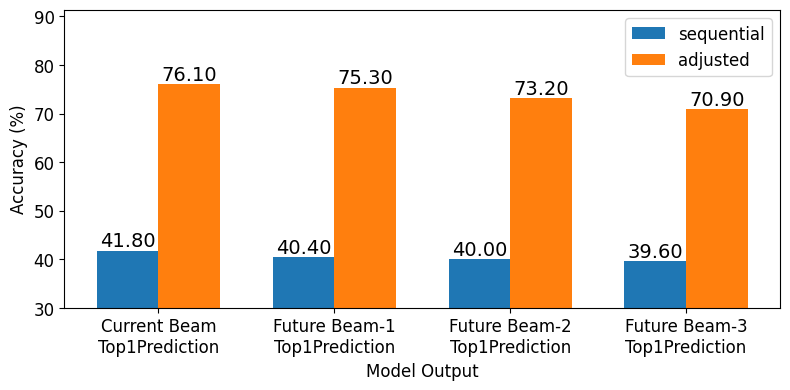

Saving plot data to F:/repo/gpsbeam/data/experiment_result/01_drone_cnn_ed_rnn_experiment_var_spliting_method_20052025_153444/model_recap/power_loss_splitting_method_data.csv


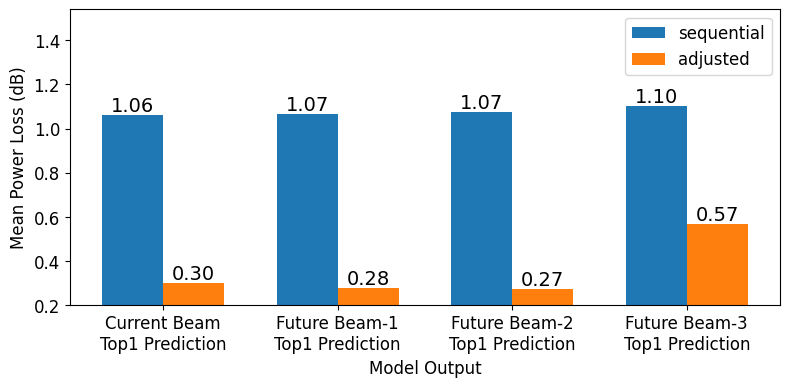

In [3]:
variable = 'splitting_method'
title = 'Dataset Splitting Method'
fig_size = (8, 4)
fontsize = 14
axis_fontsize = 12
display_title = False
compare_acc(fname, df, variable, title, fig_size=fig_size, 
            fontsize=fontsize, lower_y=30, display_title=display_title,
            y_max_multiplier=1.2, axis_fontsize=axis_fontsize)
compare_power_loss(fname, df, variable, title, fig_size=fig_size, 
                   fontsize=fontsize, lower_y=0.2, display_title=display_title,
                   y_max_multiplier=1.4, axis_fontsize=axis_fontsize)



# Feature Input Variation

In [4]:
fname = r'F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_feature_input_20052025_152755\model_recap\exp_test_result_recap.csv'
df = pd.read_csv(fname)
# df = df_apply_combined_metric(df)
df['model_input_column_list'] = df['model_input_column_list'].apply(lambda x: [str(replace_dict[i]) if i in replace_dict else i for i in ast.literal_eval(x)])
df['model_input_column_list'] = df['model_input_column_list'].astype(str)
# remove ['unit1_beam_idx_32'] on col model_input_column_list
df = df[df['model_input_column_list'] != "['unit1_beam_idx_32']"]
df

,model_input_column_list,num_classes,scenario_num,avg_loss,model_size_MiB,pred0_top1_mean_power_loss_db,pred1_top1_mean_power_loss_db,pred2_top1_mean_power_loss_db,pred3_top1_mean_power_loss_db,pred0_top1_n_beams_for_80pct_conf,pred1_top1_n_beams_for_80pct_conf,pred2_top1_n_beams_for_80pct_conf,pred3_top1_n_beams_for_80pct_conf,pred0_top1_overhead_saving_for_80pct_conf,pred1_top1_overhead_saving_for_80pct_conf,pred2_top1_overhead_saving_for_80pct_conf,pred3_top1_overhead_saving_for_80pct_conf,pred0_top1_n_beams_for_85pct_conf,pred1_top1_n_beams_for_85pct_conf,pred2_top1_n_beams_for_85pct_conf,pred3_top1_n_beams_for_85pct_conf,pred0_top1_overhead_saving_for_85pct_conf,pred1_top1_overhead_saving_for_85pct_conf,pred2_top1_overhead_saving_for_85pct_conf,pred3_top1_overhead_saving_for_85pct_conf,pred0_top1_n_beams_for_90pct_conf,pred1_top1_n_beams_for_90pct_conf,pred2_top1_n_beams_for_90pct_conf,pred3_top1_n_beams_for_90pct_conf,pred0_top1_overhead_saving_for_90pct_conf,pred1_top1_overhead_saving_for_90pct_conf,pred2_top1_overhead_saving_for_90pct_conf,pred3_top1_overhead_saving_for_90pct_conf,pred0_top1_n_beams_for_95pct_conf,pred1_top1_n_beams_for_95pct_conf,pred2_top1_n_beams_for_95pct_conf,pred3_top1_n_beams_for_95pct_conf,pred0_top1_overhead_saving_for_95pct_conf,pred1_top1_overhead_saving_for_95pct_conf,pred2_top1_overhead_saving_for_95pct_conf,pred3_top1_overhead_saving_for_95pct_conf,pred0_top1_n_beams_for_99pct_conf,pred1_top1_n_beams_for_99pct_conf,pred2_top1_n_beams_for_99pct_conf,pred3_top1_n_beams_for_99pct_conf,pred0_top1_overhead_saving_for_99pct_conf,pred1_top1_overhead_saving_for_99pct_conf,pred2_top1_overhead_saving_for_99pct_conf,pred3_top1_overhead_saving_for_99pct_conf,pred0_top1_reliability_power_loss_leq_1db_pct,pred1_top1_reliability_power_loss_leq_1db_pct,pred2_top1_reliability_power_loss_leq_1db_pct,pred3_top1_reliability_power_loss_leq_1db_pct,pred0_top1_reliability_power_loss_leq_3db_pct,pred1_top1_reliability_power_loss_leq_3db_pct,pred2_top1_reliability_power_loss_leq_3db_pct,pred3_top1_reliability_power_loss_leq_3db_pct,pred0_top1_reliability_power_loss_leq_6db_pct,pred1_top1_reliability_power_loss_leq_6db_pct,pred2_top1_reliability_power_loss_leq_6db_pct,pred3_top1_reliability_power_loss_leq_6db_pct,pred0_top1_test_acc_percent,pred0_top3_test_acc_percent,pred0_top5_test_acc_percent,pred1_top1_test_acc_percent,pred1_top3_test_acc_percent,pred1_top5_test_acc_percent,pred2_top1_test_acc_percent,pred2_top3_test_acc_percent,pred2_top5_test_acc_percent,pred3_top1_test_acc_percent,pred3_top3_test_acc_percent,pred3_top5_test_acc_percent
0,['ue_normalized_lat_lon'],32,23,3.235,0.99,0.726,0.805,0.889,1.224,1.833,1.838,1.838,1.838,94.273,94.256,94.256,94.256,2.029,2.010,2.033,2.038,93.660,93.718,93.646,93.633,2.302,2.248,2.259,2.280,92.806,92.976,92.942,92.877,2.836,2.781,2.802,2.820,91.139,91.309,91.244,91.186,4.180,4.171,4.225,4.270,86.939,86.966,86.797,86.657,90.146,90.293,91.268,90.488,96.195,96.293,96.537,96.098,98.634,98.390,98.195,97.854,64.8,89.8,96.7,63.7,90.3,97.1,63.4,89.7,96.9,62.5,88.2,96.6
1,['ue_bs_vector'],32,23,2.771,0.99,1.471,1.365,1.301,1.538,2.081,2.070,2.075,2.089,93.495,93.532,93.515,93.473,2.358,2.327,2.344,2.368,92.631,92.729,92.675,92.599,2.693,2.658,2.658,2.661,91.585,91.695,91.695,91.684,3.310,3.279,3.301,3.310,89.655,89.755,89.683,89.657,4.739,4.804,4.839,4.871,85.191,84.986,84.878,84.779,85.415,86.049,86.537,85.951,93.415,93.610,93.415,93.268,95.951,96.683,97.073,96.878,65.6,92.8,96.9,65.3,94.5,97.7,64.9,94.6,98.2,63.5,93.5,97.9
2,"['ue_normalized_lat_lon', 'ue_bs_vector']",32,23,1.475,0.99,0.299,0.278,0.272,0.567,1.560,1.527,1.533,1.542,95.127,95.227,95.209,95.180,1.688,1.660,1.689,1.718,94.726,94.811,94.723,94.631,1.896,1.844,1.863,1.890,94.075,94.236,94.177,94.093,2.271,2.210,2.252,2.294,92.902,93.093,92.962,92.831,3.320,3.319,3.430,3.496,89.625,89.630,89.280,89.075,95.366,95.268,95.707,94.341,99.171,99.024,98.927,98.390,99.659,99.659,99.512,99.220,76.1,97.3,98.8,75.3,97.8,99.3,

Saving dataframe to F:/repo/gpsbeam/data/experiment_result/01_drone_cnn_ed_rnn_experiment_var_feature_input_20052025_152755/model_recap/acc_model_input_column_list_data.csv


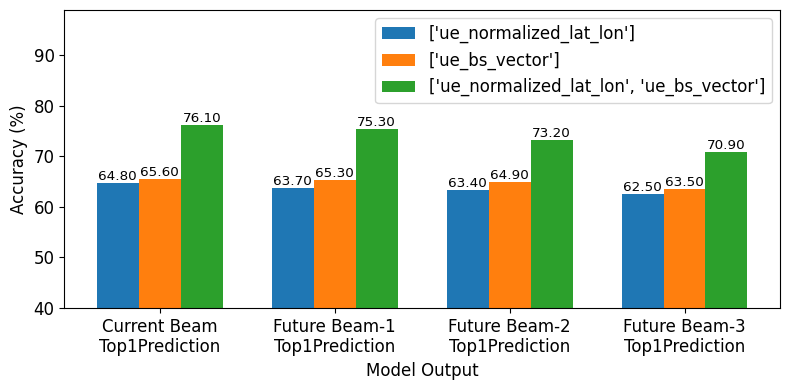

Saving plot data to F:/repo/gpsbeam/data/experiment_result/01_drone_cnn_ed_rnn_experiment_var_feature_input_20052025_152755/model_recap/power_loss_model_input_column_list_data.csv


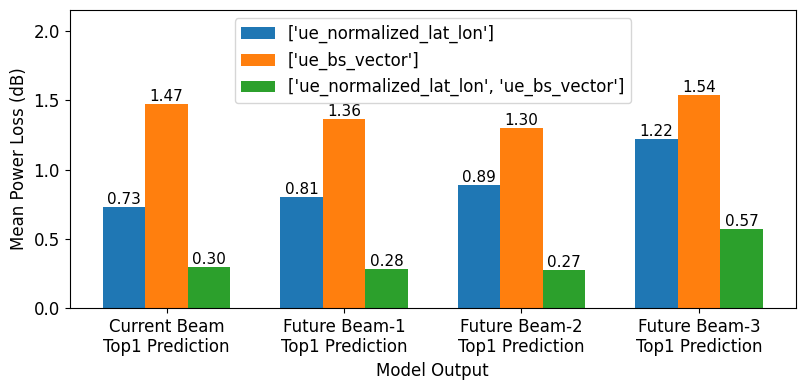

In [5]:
variable = 'model_input_column_list'
title = 'Feature Input'
fig_size = (8, 4)
fontsize = 9.7
axis_fontsize = 12
display_title = False
bar_width = 0.24
compare_acc(fname, df, variable, title, fig_size=(8,4), 
            fontsize=fontsize, lower_y=40, display_title=display_title,
            y_max_multiplier=1.3, bar_width=bar_width, axis_fontsize=axis_fontsize)

fontsize = 11
y_max_multiplier = 1.4
compare_power_loss(fname, df, variable, title, fig_size=fig_size, 
                   fontsize=fontsize, lower_y=0, display_title=display_title,
                   y_max_multiplier=y_max_multiplier, bar_width=bar_width, axis_fontsize=axis_fontsize)


# Num Class Variation

In [6]:
fname = r'F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_num_classes_20052025_154009\model_recap\exp_test_result_recap.csv'
df = pd.read_csv(fname)
# df = df_apply_combined_metric(df)
df

,num_classes,model_input_column_list,scenario_num,avg_loss,model_size_MiB,pred0_top1_mean_power_loss_db,pred1_top1_mean_power_loss_db,pred2_top1_mean_power_loss_db,pred3_top1_mean_power_loss_db,pred0_top1_n_beams_for_80pct_conf,pred1_top1_n_beams_for_80pct_conf,pred2_top1_n_beams_for_80pct_conf,pred3_top1_n_beams_for_80pct_conf,pred0_top1_overhead_saving_for_80pct_conf,pred1_top1_overhead_saving_for_80pct_conf,pred2_top1_overhead_saving_for_80pct_conf,pred3_top1_overhead_saving_for_80pct_conf,pred0_top1_n_beams_for_85pct_conf,pred1_top1_n_beams_for_85pct_conf,pred2_top1_n_beams_for_85pct_conf,pred3_top1_n_beams_for_85pct_conf,pred0_top1_overhead_saving_for_85pct_conf,pred1_top1_overhead_saving_for_85pct_conf,pred2_top1_overhead_saving_for_85pct_conf,pred3_top1_overhead_saving_for_85pct_conf,pred0_top1_n_beams_for_90pct_conf,pred1_top1_n_beams_for_90pct_conf,pred2_top1_n_beams_for_90pct_conf,pred3_top1_n_beams_for_90pct_conf,pred0_top1_overhead_saving_for_90pct_conf,pred1_top1_overhead_saving_for_90pct_conf,pred2_top1_overhead_saving_for_90pct_conf,pred3_top1_overhead_saving_for_90pct_conf,pred0_top1_n_beams_for_95pct_conf,pred1_top1_n_beams_for_95pct_conf,pred2_top1_n_beams_for_95pct_conf,pred3_top1_n_beams_for_95pct_conf,pred0_top1_overhead_saving_for_95pct_conf,pred1_top1_overhead_saving_for_95pct_conf,pred2_top1_overhead_saving_for_95pct_conf,pred3_top1_overhead_saving_for_95pct_conf,pred0_top1_n_beams_for_99pct_conf,pred1_top1_n_beams_for_99pct_conf,pred2_top1_n_beams_for_99pct_conf,pred3_top1_n_beams_for_99pct_conf,pred0_top1_overhead_saving_for_99pct_conf,pred1_top1_overhead_saving_for_99pct_conf,pred2_top1_overhead_saving_for_99pct_conf,pred3_top1_overhead_saving_for_99pct_conf,pred0_top1_reliability_power_loss_leq_1db_pct,pred1_top1_reliability_power_loss_leq_1db_pct,pred2_top1_reliability_power_loss_leq_1db_pct,pred3_top1_reliability_power_loss_leq_1db_pct,pred0_top1_reliability_power_loss_leq_3db_pct,pred1_top1_reliability_power_loss_leq_3db_pct,pred2_top1_reliability_power_loss_leq_3db_pct,pred3_top1_reliability_power_loss_leq_3db_pct,pred0_top1_reliability_power_loss_leq_6db_pct,pred1_top1_reliability_power_loss_leq_6db_pct,pred2_top1_reliability_power_loss_leq_6db_pct,pred3_top1_reliability_power_loss_leq_6db_pct,pred0_top1_test_acc_percent,pred0_top3_test_acc_percent,pred0_top5_test_acc_percent,pred1_top1_test_acc_percent,pred1_top3_test_acc_percent,pred1_top5_test_acc_percent,pred2_top1_test_acc_percent,pred2_top3_test_acc_percent,pred2_top5_test_acc_percent,pred3_top1_test_acc_percent,pred3_top3_test_acc_percent,pred3_top5_test_acc_percent
0,8,"['unit2_loc_minmax_norm', 'unit2to1_vector']",23,0.349,0.99,0.232,0.343,0.521,0.731,1.194,1.213,1.233,1.248,85.077,84.841,84.593,84.401,1.235,1.257,1.282,1.298,84.562,84.290,83.974,83.775,1.294,1.317,1.350,1.364,83.831,83.540,83.125,82.945,1.443,1.478,1.501,1.530,81.966,81.520,81.235,80.875,1.969,2.024,2.111,2.192,75.390,74.703,73.618,72.602,96.282,95.885,95.141,94.695,98.761,98.265,97.819,97.620,99.603,99.554,99.008,98.810,88.0,99.7,100.0,88.1,99.5,100.0,86.4,99.5,100.0,85.9,99.2,99.9
1,16,"['unit2_loc_minmax_norm', 'unit2to1_vector']",23,0.454,0.99,0.292,0.238,0.280,0.407,1.258,1.255,1.279,1.294,92.136,92.155,92.004,91.915,1.318,1.317,1.329,1.352,91.762,91.771,91.691,91.547,1.412,1.391,1.416,1.443,91.176,91.305,91.148,90.982,1.581,1.568,1.621,1.643,90.120,90.200,89.869,89.734,2.240,2.262,2.362,2.437,86.000,85.862,85.236,84.766,95.238,95.876,96.514,95.287,98.527,98.871,98.675,98.135,99.460,99.656,99.558,99.313,84.1,98.6,99.4,86.0,98.8,99.3,86.0,99.0,99.6,84.3,98.5,99.5
2,32,"['unit2_loc_minmax_norm', 'unit2to1_vector']",23,1.475,0.99,0.299,0.278,0.272,0.567,1.560,1.527,1.533,1.542,95.127,95.227,95.209,95.180,1.688,1.660,1.689,1.718,94.726,94.811,94.723,94.631,1.896,1.844,1.863,1.890,94.075,94.236,94.177,94.093,2.271,2.210,2.252,2.294,92.902,93.093,92.962,92.831,3.320,3.319,3.430,3.496,89.625,89.630,89.280,89.075,95.366,95.268,95.707,94.341,99.171,99.024,98.927,98.390,99

Saving dataframe to F:/repo/gpsbeam/data/experiment_result/01_drone_cnn_ed_rnn_experiment_var_num_classes_20052025_154009/model_recap/acc_num_classes_data.csv


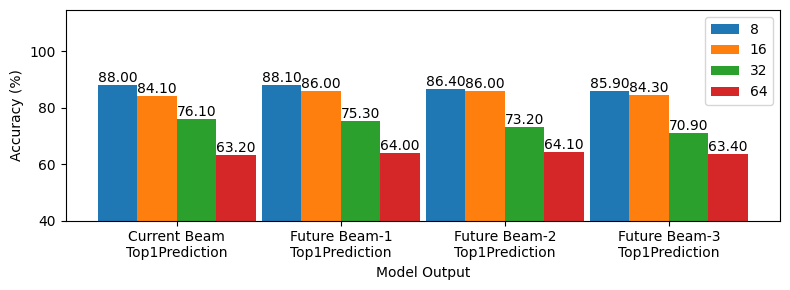

Saving plot data to F:/repo/gpsbeam/data/experiment_result/01_drone_cnn_ed_rnn_experiment_var_num_classes_20052025_154009/model_recap/power_loss_num_classes_data.csv


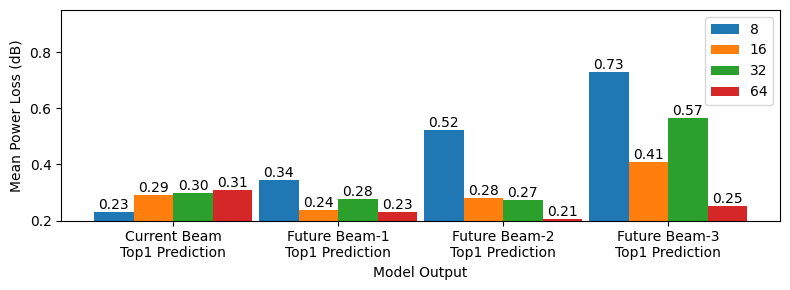

In [7]:
variable = 'num_classes'
title = 'Beam Codebook Size'
fig_size = (8, 3)
fontsize = 10
display_title = False
bar_width = 0.24
y_max_multiplier = 1.3
compare_acc(fname, df, variable, title, fig_size=(8,3), fontsize=fontsize, lower_y=40, display_title=display_title,
            y_max_multiplier=y_max_multiplier, bar_width=bar_width)
compare_power_loss(fname, df, variable, title, fig_size=fig_size, fontsize=fontsize, lower_y=0.2, display_title=display_title,
                   y_max_multiplier=y_max_multiplier, bar_width=bar_width)


# Visualize Beam Power

In [8]:
data_config_obj = DataConfig(train_val_test_split_frac=[0.65, 0.15, 0.2], 
                             splitting_method='adjusted',
                             num_classes=64,
                             scenario_num=23)

dataprep_obj = DataPrep(data_config_obj)

dataprep_obj.get_train_val_test_dataset()

2025-05-20 16:05:19.344 | INFO     | src.data.dataprep:get_train_val_test_dataset:296 - 
Dataset is LOADED from f:/repo/gpsbeam\data/processed/Scenario23/dset_scenario23_seednum42_train0.65_test0.2_portion100_beam64_splitting_method_adjusted.hkl
2025-05-20 16:05:19.345 | INFO     | src.data.dataprep:get_train_val_test_dataset:311 - 
                    RAW DATASET INFO
                    ------------------------------
                    Scenario Num                                    : 23,
                    Splitting Method                                : adjusted
                    Portion Percentage                              : 100
                    Training                                        : 7371 samples [64.73%]
                    Validation                                      : 1685 samples [14.80%]
                    Testing                                         : 2331 samples [20.47%]
                    Total                                           : 1138

In [9]:
train_dset = dataprep_obj.dataset_dict['train']
train_df =dataprep_obj.convert_to_df(train_dset)

train_df.head(1)

,sample_idx,from_scenario,seednum,seq_index,unit1_pwr_60ghz,unit1_beam_idx_8,unit1_beam_idx_16,unit1_beam_idx_32,unit1_beam_idx_64,unit1_lidar,unit1_lidar_scr,unit1_radar,unit1_rgb,unit2_hdop,unit2_pdop,unit1_loc,unit2_loc,unit2_loc_minmax_norm,unit2_speed,unit2_altitude,unit2_distance,unit2_height,unit2_x-speed,unit2_y-speed,unit2_z-speed,unit2_pitch,unit2_roll,unit2_height_log,unit2_height_minmax_norm,unit2to1_vector,unit1_loc_vector,unit2_loc_vector
0,1,23,42,1,f:/repo/gpsbeam\data/raw/Scenario23//unit1/mmWave_data/mmWave_power_1.txt,5,11,21,42,None,None,None,f:/repo/gpsbeam\data/raw/Scenario23//unit1/camera_data/image_BS1_1_16_58_42.jpg,0.0,0.0,"(33.31101852725683, -111.89238645275388)","(33.31107324, -111.89234850000001)","(0.3195560203421424, 0.4874879026449761)",2.281679,1207.274108,10.683366,31.496064,-2.23694,-0.447388,-4.921268,-6.7,-1.9,3.481119,0.080537,"(-0.16403205548298952, -0.7018817529118233, 0.6931489664591959)","(-0.31223244318808985, -0.777000929755819, 0.5466081380471653)","(-0.31223173129849896, -0.7770006458295892, 0.5466089482900397)"


Text(0.5, 1.0, 'Power Plot on sample 1')

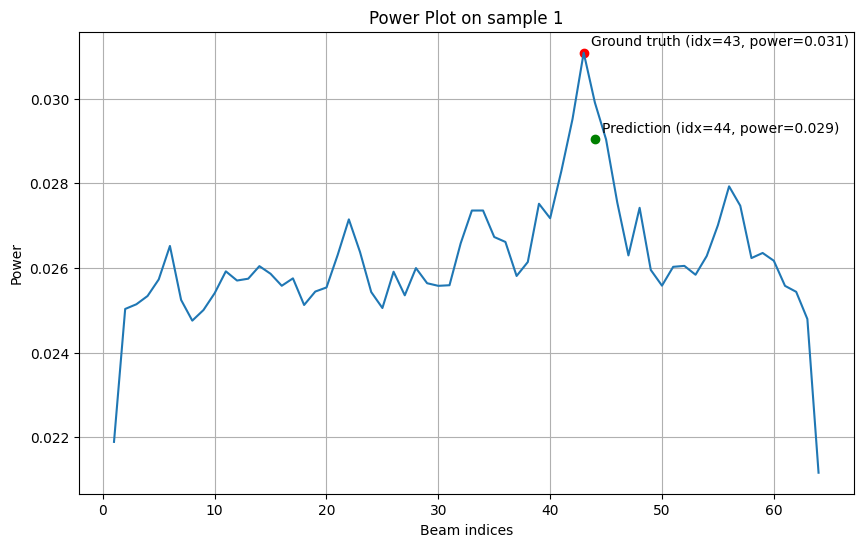

In [10]:
selected_sample_idx = 1
value = train_df.iloc[selected_sample_idx]['unit1_pwr_60ghz']
value = np.loadtxt(value)
N_BEAMS = 64
beam_idxs = np.arange(N_BEAMS) + 1
plt.figure(figsize=(10,6))
plt.plot(beam_idxs, value.T)
# plt.legend([f'Sample {i}' for i in selected_samples])
# get the highest power in the array
max_power = np.max(value)
max_power_idx = np.argmax(value) + 1  # Adding 1 to match beam_idxs
plt.scatter(max_power_idx, max_power, c='r', marker='o')
plt.annotate(f'Ground truth (idx={max_power_idx}, power={max_power:.3f})', 
             (max_power_idx, max_power), 
             xytext=(5, 5), 
             textcoords='offset points')


pred_power_idx = 44
pred_power = value[pred_power_idx]
plt.scatter(pred_power_idx, pred_power, c='g', marker='o')
plt.annotate(f'Prediction (idx={pred_power_idx}, power={pred_power:.3f})', 
             (pred_power_idx, pred_power), 
             xytext=(5, 5), 
             textcoords='offset points')


plt.xlabel('Beam indices')
plt.ylabel('Power')
plt.grid()
title = f"Power Plot on sample {selected_sample_idx}"
plt.title(title)


# Confusion Matrix

In [11]:
fname = r'F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\05-20-2025_15_10_42\dl_generated\model_inference_result\test_epoch_00_inference_detail.csv'
df = pd.read_csv(fname)
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x))
df['top5_preds'] = df['top5_preds'].apply(lambda x: ast.literal_eval(x))
df['pred0_top1'] = df['top5_preds'].apply(lambda x: x[0][0])
df['label0'] = df['labels'].apply(lambda x: x[0])
df['pred0_top1_match'] = df.apply(lambda x: x['pred0_top1'] == x['labels'][0], axis=1)
pred0_top1_match_count = df['pred0_top1_match'].sum()
total_samples = len(df)
accuracy = pred0_top1_match_count / total_samples
print(f'Accuracy: {accuracy:.4f}')

df.head(1)

Accuracy: 0.7615


,input_from_scenario,input_seq_idx,input_speed,input_height,input_pitch,input_roll,input_sample_idx,future_sample_idx,loss,top5_preds,n_beams_for_80pct_conf,n_beams_for_85pct_conf,n_beams_for_90pct_conf,n_beams_for_95pct_conf,n_beams_for_99pct_conf,labels,train_entropy,true_power,pred_power,power_loss_ratio,power_loss_db,noise_power,n_beams_within_tresh,avg_power,is_power_loss_leq_1db,is_power_loss_leq_3db,is_power_loss_leq_6db,pred0_top1,label0,pred0_top1_match
0,"[0, 0, 0, 0, 23, 23, 23, 23]","[0, 0, 0, 0, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 7.60559606552124, 6.487125873565674, 5.816043853759766, 4.697574138641357]","[0.0, 0.0, 0.0, 0.0, 103.67454528808594, 103.67454528808594, 103.67454528808594, 103.67454528808594]","[0.0, 0.0, 0.0, 0.0, -3.4000000953674316, -3.299999952316284, -2.799999952316284, -1.399999976158142]","[0.0, 0.0, 0.0, 0.0, 13.100000381469727, 12.600000381469727, 12.199999809265137, 9.5]","[0, 0, 0, 0, 203, 204, 205, 206]","[206, 207, 208, 209]",0.687,"[[14, 15, 13, 16, 19], [14, 15, 13, 16, 19], [14, 15, 13, 16, 19], [14, 15, 16, 13, 19]]","[2, 2, 2, 2]","[2, 2, 2, 2]","[2, 2, 2, 2]","[3, 3, 2, 2]","[4, 4, 4, 4]","[14, 14, 14, 14]",2.652217,[0.87500858 0.90693605 0.92205346 0.86113966],[0.87500858 0.90693605 0.92205346 0.86113966],[1. 1. 1. 1.],"[0.0, 0.0, 0.0, 0.0]",[0.02871107 0.03766098 0.0297823 0.02909119],[3 3 3 3],[0.20041257 0.21135927 0.21592139 0.20466872],"[True, True, True, True]","[True, True, True, True]","[True, True, True, True]",14,14,True


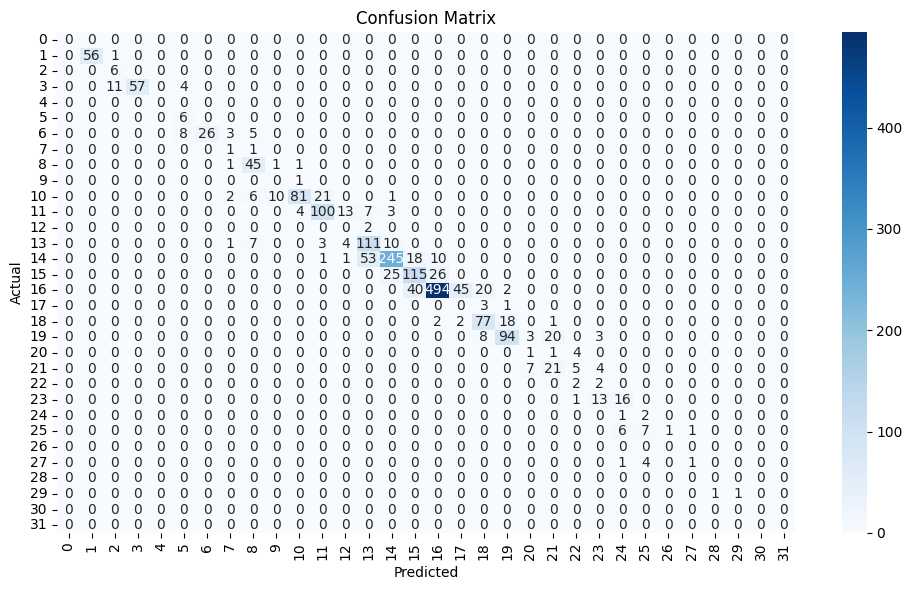

In [12]:
# make confusion matrix
confusion_matrix = pd.crosstab(df['pred0_top1'], df['label0'], rownames=['Predicted'], colnames=['Actual'])

# Ensure all labels 0-31 are present
num_classes = 32
all_labels = list(range(num_classes))
for label in all_labels:
    if label not in confusion_matrix.index:
        confusion_matrix.loc[label] = 0
    if label not in confusion_matrix.columns:
        confusion_matrix[label] = 0

# Sort indices and columns
confusion_matrix = confusion_matrix.sort_index()
confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.columns), axis=1)

# plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_labels,
            yticklabels=all_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [13]:
# Count incorrect predictions for each label
incorrect_counts = df[~df['pred0_top1_match']].groupby('label0').size().sort_values(ascending=False)

# Create table with counts and percentages of incorrect predictions
label_stats = pd.DataFrame({
    'Incorrect Count': incorrect_counts,
})

label_stats.head(5)

,Incorrect Count
label0,
13,62
15,58
17,47
14,39
16,38


In [14]:
def analyze_feature_spreads(df, features=['input_speed', 'input_height', 'input_pitch', 'input_roll']):
    """
    Analyze the spread statistics of features between correct and incorrect predictions.
    
    Args:
        df: DataFrame containing the prediction data
        features: List of feature columns to analyze
        
    Returns:
        pd.DataFrame: Table of spread statistics styled with caption
    """
    spread_stats = []
    for col in features:
        # Extract last value from each list
        df[f'{col}_last'] = df[col].apply(lambda x: ast.literal_eval(x)[-1])
        
        # Calculate statistics for correct vs incorrect predictions
        correct_stats = df[df['pred0_top1_match']][f'{col}_last'].describe()
        incorrect_stats = df[~df['pred0_top1_match']][f'{col}_last'].describe()
        
        # Calculate spread metrics
        spread_diff = abs(correct_stats['mean'] - incorrect_stats['mean'])
        
        # Add row to spread_stats
        spread_stats.append({
            'Feature': col.replace('input_', '').capitalize(),
            'Correct Mean': f"{correct_stats['mean']:.4f}",
            'Correct Std': f"{correct_stats['std']:.4f}", 
            'Incorrect Mean': f"{incorrect_stats['mean']:.4f}",
            'Incorrect Std': f"{incorrect_stats['std']:.4f}",
            'Mean Difference': f"{spread_diff:.4f}"
        })

    # Add ratio of standard deviations
    for stat in spread_stats:
        correct_std = float(stat['Correct Std'])
        incorrect_std = float(stat['Incorrect Std']) 
        std_ratio = incorrect_std / correct_std
        stat['Std Ratio (Incorrect/Correct)'] = f"{std_ratio:.4f}"

    spread_df = pd.DataFrame(spread_stats)
    return spread_df.style.set_caption("Spread Analysis by Feature")

# Display the spread analysis
df_select = df[df['label0']==18]
display(analyze_feature_spreads(df_select))

C:\Users\vendi\AppData\Local\Temp\ipykernel_2396\784202081.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_last'] = df[col].apply(lambda x: ast.literal_eval(x)[-1])
C:\Users\vendi\AppData\Local\Temp\ipykernel_2396\784202081.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_last'] = df[col].apply(lambda x: ast.literal_eval(x)[-1])
C:\Users\vendi\AppData\Local\Temp\ipykernel_2396\784202081.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,Feature,Correct Mean,Correct Std,Incorrect Mean,Incorrect Std,Mean Difference,Std Ratio (Incorrect/Correct)
0,Speed,7.5556,5.1838,3.7602,3.9883,3.7954,0.7694
1,Height,168.1622,91.5645,88.1488,62.8156,80.0135,0.6860
2,Pitch,-2.3662,3.4107,0.2194,3.6488,2.5856,1.0698
3,Roll,-9.7325,12.5753,-2.5355,10.9695,7.1970,0.8723


108


C:\Users\vendi\AppData\Local\Temp\ipykernel_2396\486908947.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['current_value'] = df[col_name].apply(lambda x: ast.literal_eval(x)[-1])


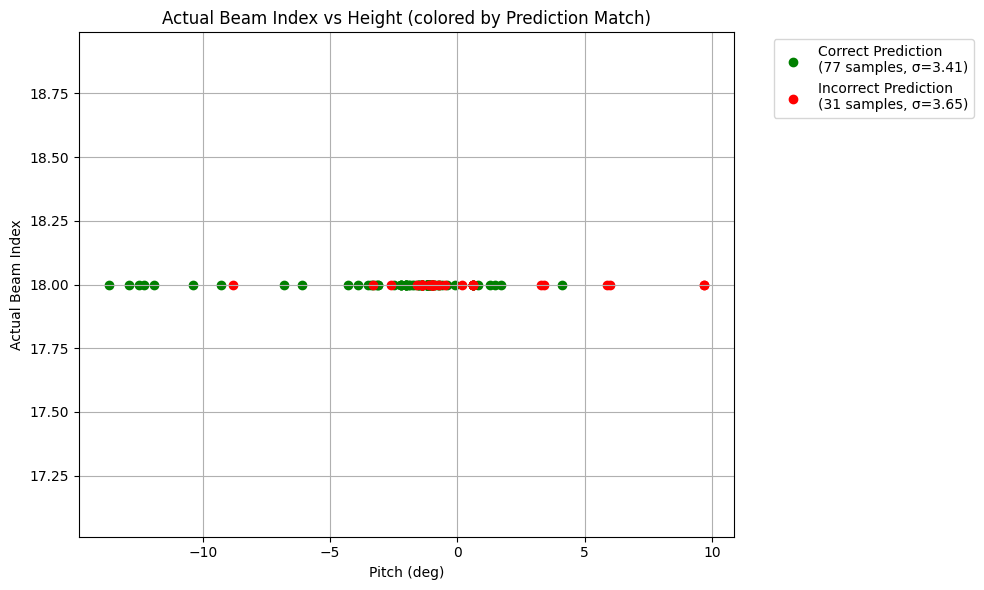

In [15]:
def plot_beam_prediction_scatter(df, col_name='input_speed'):
    """
    Create scatter plot of speed/height vs actual beam indices colored by prediction match
    
    Args:
        df: DataFrame containing the data
        col_name: Column name to use for axis ('input_speed' or 'input_height') 
    """
    # Get the last value from the list in the column and convert units if needed
    if col_name == 'input_speed':
        df['current_value'] = df[col_name].apply(lambda x: ast.literal_eval(x)[-1] * 2.23694)  # m/s to mph
        ylabel = 'Speed (mph)'
    elif col_name == 'input_height':  # input_height
        df['current_value'] = df[col_name].apply(lambda x: ast.literal_eval(x)[-1])
        ylabel = 'Height (m)'
    elif col_name == 'input_pitch':
        df['current_value'] = df[col_name].apply(lambda x: ast.literal_eval(x)[-1])
        ylabel = 'Pitch (deg)'
    elif col_name == 'input_roll':
        df['current_value'] = df[col_name].apply(lambda x: ast.literal_eval(x)[-1])
        ylabel = 'Roll (deg)'

    # Create scatter plot
    plt.figure(figsize=(10,6))
    
    # Plot points colored by prediction match
    correct_mask = df['pred0_top1_match'] == True
    incorrect_mask = df['pred0_top1_match'] == False
    
    n_correct = sum(correct_mask)
    n_incorrect = sum(incorrect_mask)
    
    # Calculate spread statistics
    correct_spread = df[correct_mask]['current_value'].std()
    incorrect_spread = df[incorrect_mask]['current_value'].std()
    
    plt.scatter(df[correct_mask]['current_value'], df[correct_mask]['label0'], 
               c='green', label=f'Correct Prediction\n({n_correct} samples, σ={correct_spread:.2f})')
    plt.scatter(df[incorrect_mask]['current_value'], df[incorrect_mask]['label0'],
               c='red', label=f'Incorrect Prediction\n({n_incorrect} samples, σ={incorrect_spread:.2f})')
    
    plt.xlabel(ylabel)
    plt.ylabel('Actual Beam Index')
    title_suffix = 'Speed' if col_name == 'input_speed' else 'Height'
    plt.title(f'Actual Beam Index vs {title_suffix} (colored by Prediction Match)')

    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
df_slabel = df[(df['label0']==18)]
print(len(df_slabel))
plot_beam_prediction_scatter(df_slabel, 'input_pitch')

In [16]:
df.head(1)

,input_from_scenario,input_seq_idx,input_speed,input_height,input_pitch,input_roll,input_sample_idx,future_sample_idx,loss,top5_preds,n_beams_for_80pct_conf,n_beams_for_85pct_conf,n_beams_for_90pct_conf,n_beams_for_95pct_conf,n_beams_for_99pct_conf,labels,train_entropy,true_power,pred_power,power_loss_ratio,power_loss_db,noise_power,n_beams_within_tresh,avg_power,is_power_loss_leq_1db,is_power_loss_leq_3db,is_power_loss_leq_6db,pred0_top1,label0,pred0_top1_match
0,"[0, 0, 0, 0, 23, 23, 23, 23]","[0, 0, 0, 0, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 7.60559606552124, 6.487125873565674, 5.816043853759766, 4.697574138641357]","[0.0, 0.0, 0.0, 0.0, 103.67454528808594, 103.67454528808594, 103.67454528808594, 103.67454528808594]","[0.0, 0.0, 0.0, 0.0, -3.4000000953674316, -3.299999952316284, -2.799999952316284, -1.399999976158142]","[0.0, 0.0, 0.0, 0.0, 13.100000381469727, 12.600000381469727, 12.199999809265137, 9.5]","[0, 0, 0, 0, 203, 204, 205, 206]","[206, 207, 208, 209]",0.687,"[[14, 15, 13, 16, 19], [14, 15, 13, 16, 19], [14, 15, 13, 16, 19], [14, 15, 16, 13, 19]]","[2, 2, 2, 2]","[2, 2, 2, 2]","[2, 2, 2, 2]","[3, 3, 2, 2]","[4, 4, 4, 4]","[14, 14, 14, 14]",2.652217,[0.87500858 0.90693605 0.92205346 0.86113966],[0.87500858 0.90693605 0.92205346 0.86113966],[1. 1. 1. 1.],"[0.0, 0.0, 0.0, 0.0]",[0.02871107 0.03766098 0.0297823 0.02909119],[3 3 3 3],[0.20041257 0.21135927 0.21592139 0.20466872],"[True, True, True, True]","[True, True, True, True]","[True, True, True, True]",14,14,True


# Analyze Inference Detail with Same height sample

In [17]:
# Categorize height and speed
def categorize_height(height):
    if height <= 40:
        return 'Low(≤40 m)'
    elif height <= 80:
        return 'Medium(40~80 m)'
    return 'High(>80 m)'

def categorize_speed(speed_mph):
    if speed_mph <= 10:
        return 'Slow(≤10 mph)'
    elif speed_mph <= 20:
        return 'Medium(10~20 mph)'
    return 'Fast(>20 mph)'

def parse_array(x, col_name):
    if 'power' in col_name:
        return np.array([float(num) for num in x.strip('[]').split()])
    if 'tresh' in col_name:
        return np.array([int(num) for num in x.strip('[]').split()])
    return ast.literal_eval(x)
def process_inference_data(df):
    """
    Process inference data by parsing arrays and adding derived columns
    
    Args:
        df (pd.DataFrame): Input dataframe with raw inference data
        
    Returns:
        pd.DataFrame: Processed dataframe with parsed arrays and additional columns
    """
    # Create new dataframe to avoid SettingWithCopyWarning
    result_df = pd.DataFrame()
    
    # Parse arrays
    arrays = {
        'top5_preds': df['top5_preds'].apply(lambda x: parse_array(x, 'top5_preds')),
        'labels': df['labels'].apply(lambda x: parse_array(x, 'labels')),
        'avg_power': df['avg_power'].apply(lambda x: parse_array(x, 'avg_power')),
        'power_loss_ratio': df['power_loss_ratio'].apply(lambda x: parse_array(x, 'power_loss_ratio'))
    }
    
    # Add speed and height columns
    result_df['current_speed_mph'] = df['input_speed'].apply(lambda x: parse_array(x, 'input_speed')[-1] * 2.23694)
    result_df['current_height'] = df['input_height'].apply(lambda x: parse_array(x, 'input_height')[-1])
    
    # Add predictions for each timestep (0-3)
    for i in range(4):
        result_df[f'{i}th_pred'] = arrays['top5_preds'].apply(lambda x: x[i][0])
        result_df[f'{i}th_label'] = arrays['labels'].apply(lambda x: x[i])
        result_df[f'{i}th_match'] = result_df[f'{i}th_pred'] == result_df[f'{i}th_label']
        result_df[f'{i}th_avg_power'] = arrays['avg_power'].apply(lambda x: x[i])
        result_df[f'{i}th_power_loss_ratio'] = arrays['power_loss_ratio'].apply(lambda x: x[i])
    
    # Add categorized columns
    result_df['height_category'] = result_df['current_height'].apply(categorize_height)
    result_df['speed_category'] = result_df['current_speed_mph'].apply(categorize_speed)

    # Reorder columns
    selected_col = ['current_speed_mph', 'speed_category', 'current_height', 'height_category']
    for i in range(4):
        selected_col.extend([f'{i}th_pred', f'{i}th_label', f'{i}th_match', f'{i}th_avg_power', f'{i}th_power_loss_ratio'])
        
    return result_df[selected_col]

In [18]:
# use inference detail file
fname = r'F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\05-20-2025_15_10_42\dl_generated\model_inference_result\test_epoch_00_inference_detail.csv'
df = pd.read_csv(fname)
df = process_inference_data(df)
df.head(1)


,current_speed_mph,speed_category,current_height,height_category,0th_pred,0th_label,0th_match,0th_avg_power,0th_power_loss_ratio,1th_pred,1th_label,1th_match,1th_avg_power,1th_power_loss_ratio,2th_pred,2th_label,2th_match,2th_avg_power,2th_power_loss_ratio,3th_pred,3th_label,3th_match,3th_avg_power,3th_power_loss_ratio
0,10.508191,Medium(10~20 mph),103.674545,High(>80 m),14,14,True,0.200413,1.0,14,14,True,0.211359,1.0,14,14,True,0.215921,1.0,14,14,True,0.204669,1.0


In [19]:
def calculate_category_metrics(df, category_col, equal_sampling=False, n_runs=10):
    """Calculate accuracy and power loss metrics for each category.
    
    Args:
        df (pd.DataFrame): Input dataframe with inference results
        category_col (str): Column name for category to analyze ('speed_category' or 'height_category')
        equal_sampling (bool): Whether to use equal sampling across categories
        n_runs (int): Number of runs for averaging metrics
        
    Returns:
        pd.DataFrame: DataFrame with metrics per category
    """
    # Create results dataframe
    category_metrics = pd.DataFrame()
    
    # Get number of samples in each category
    sample_counts = df.groupby(category_col).size()
    
    if equal_sampling:
        # Get minimum sample count across categories
        min_samples = sample_counts.min()
        # Set all categories to min_samples count
        category_metrics['num_samples'] = min_samples
        
        # Initialize arrays for storing metrics from multiple runs
        n_categories = len(sample_counts)
        acc_runs = np.zeros((n_runs, n_categories, 4))  # 4 timesteps
        power_loss_runs = np.zeros((n_runs, n_categories, 4))
        
        # Run multiple times with equal sampling
        for run in range(n_runs):
            # Sample equal number from each category
            sampled_df = pd.DataFrame()
            for cat in sample_counts.index:
                cat_df = df[df[category_col] == cat]
                sampled_cat = cat_df.sample(n=min_samples, replace=False, random_state=run)
                sampled_df = pd.concat([sampled_df, sampled_cat])
            
            # Calculate metrics for each timestep
            for i in range(4):
                acc = sampled_df.groupby(category_col)[f'{i}th_match'].mean() * 100
                power_loss = 10 * np.log10(sampled_df.groupby(category_col)[f'{i}th_power_loss_ratio'].mean())
                
                acc_runs[run, :, i] = acc.values
                power_loss_runs[run, :, i] = power_loss.values
        
        # Calculate mean and std across runs
        category_metrics = pd.DataFrame()
        category_metrics[category_col] = sample_counts.index
        category_metrics['num_samples'] = min_samples
        category_metrics["num_of_sampling"] = n_runs
        
        for i in range(4):
            acc_mean = np.mean(acc_runs[:, :, i], axis=0)
            acc_std = np.std(acc_runs[:, :, i], axis=0)
            power_loss_mean = np.mean(power_loss_runs[:, :, i], axis=0)
            power_loss_std = np.std(power_loss_runs[:, :, i], axis=0)
            
            # Add to results with mean ± std format
            category_metrics[f'{i}th_pred_acc'] = [f"{m:.2f}±{s:.2f}" for m, s in zip(acc_mean, acc_std)]
            category_metrics[f'{i}th_mean_power_loss_db'] = [f"{m:.2f}±{s:.2f}" for m, s in zip(power_loss_mean, power_loss_std)]
    
    else:
        # Original calculation without equal sampling
        category_metrics['num_samples'] = sample_counts
        for i in range(4):
            acc = df.groupby(category_col)[f'{i}th_match'].mean() * 100
            mean_power_loss_db = 10 * np.log10(df.groupby(category_col)[f'{i}th_power_loss_ratio'].mean())
            
            category_metrics[f'{i}th_pred_acc'] = acc.round(2)
            category_metrics[f'{i}th_mean_power_loss_db'] = mean_power_loss_db.round(2)

    # Reset index
    category_metrics = category_metrics.reset_index()
    
    # Sort based on category type
    if category_col == 'speed_category':
        sort_order = ['Slow(≤10 mph)', 'Medium(10~20 mph)', 'Fast(>20 mph)']
    else:  # height_category
        sort_order = ['Low(≤40 m)', 'Medium(40~80 m)', 'High(>80 m)']
        
    category_metrics[category_col] = pd.Categorical(
        category_metrics[category_col], 
        categories=sort_order,
        ordered=True
    )
    category_metrics = category_metrics.sort_values(category_col)
    
    return category_metrics

# Calculate metrics for speed categories
# Equal_sampling = False -> all samples are used to calculate the metrics.
# Equal_sampling = True -> samples are sampled equally from each category.
#                          The number of samples depends on the category with the least samples,
#                          then calculate the metrics on those selected samples.
#                          This process is repeated n_runs times and the mean and std are calculated.
speed_metrics = calculate_category_metrics(df, 'speed_category', equal_sampling=False)
speed_metrics


,speed_category,num_samples,0th_pred_acc,0th_mean_power_loss_db,1th_pred_acc,1th_mean_power_loss_db,2th_pred_acc,2th_mean_power_loss_db,3th_pred_acc,3th_mean_power_loss_db
2,Slow(≤10 mph),1434,80.26,0.11,78.38,0.14,76.15,0.12,75.66,0.15
1,Medium(10~20 mph),287,70.73,0.70,71.43,0.40,70.03,0.30,64.46,0.30
0,Fast(>20 mph),329,62.92,0.71,65.35,0.73,62.92,0.84,55.62,2.19


In [20]:
speed_metrics = calculate_category_metrics(df, 'speed_category', equal_sampling=True, n_runs=20)
speed_metrics

,index,speed_category,num_samples,num_of_sampling,0th_pred_acc,0th_mean_power_loss_db,1th_pred_acc,1th_mean_power_loss_db,2th_pred_acc,2th_mean_power_loss_db,3th_pred_acc,3th_mean_power_loss_db
2,2,Slow(≤10 mph),287,20,80.00±2.19,0.13±0.03,77.98±2.27,0.15±0.03,75.70±2.27,0.13±0.02,75.54±2.67,0.16±0.04
1,1,Medium(10~20 mph),287,20,70.73±0.00,0.70±0.00,71.43±0.00,0.40±0.00,70.03±0.00,0.30±0.00,64.46±0.00,0.30±0.00
0,0,Fast(>20 mph),287,20,63.28±0.83,0.72±0.04,65.63±0.94,0.76±0.05,62.72±0.81,0.86±0.05,55.80±0.90,2.23±0.14


In [21]:
height_metrics = calculate_category_metrics(df, 'height_category', equal_sampling=False)
height_metrics

,height_category,num_samples,0th_pred_acc,0th_mean_power_loss_db,1th_pred_acc,1th_mean_power_loss_db,2th_pred_acc,2th_mean_power_loss_db,3th_pred_acc,3th_mean_power_loss_db
1,Low(≤40 m),56,76.79,0.46,75.00,0.06,66.07,0.07,69.64,0.16
2,Medium(40~80 m),695,67.77,0.49,71.22,0.30,67.19,0.35,65.32,1.16
0,High(>80 m),1299,80.60,0.19,77.52,0.27,76.67,0.24,73.90,0.23


In [22]:
height_metrics = calculate_category_metrics(df, 'height_category', equal_sampling=True, n_runs=20)
height_metrics

,index,height_category,num_samples,num_of_sampling,0th_pred_acc,0th_mean_power_loss_db,1th_pred_acc,1th_mean_power_loss_db,2th_pred_acc,2th_mean_power_loss_db,3th_pred_acc,3th_mean_power_loss_db
1,1,Low(≤40 m),56,20,76.79±0.00,0.46±0.00,75.00±0.00,0.06±0.00,66.07±0.00,0.07±0.00,69.64±0.00,0.16±0.00
2,2,Medium(40~80 m),56,20,69.29±6.10,0.34±0.31,73.39±5.59,0.23±0.26,69.38±4.53,0.27±0.23,65.18±5.66,1.08±0.75
0,0,High(>80 m),56,20,79.55±3.89,0.17±0.12,76.52±4.46,0.24±0.17,74.91±6.38,0.21±0.11,71.88±7.18,0.30±0.16


In [23]:
def create_multiindex_columns(df, category_name):
    """Create a multi-index columns for the metrics dataframe.
    
    Args:
        df: DataFrame to modify columns for
        category_name: Name of the category column (e.g. 'height_category' or 'speed_category')
        
    Returns:
        DataFrame with multi-index columns
    """
    columns = pd.MultiIndex.from_tuples([
        ('index', '', ''),
        (category_name, '', ''),
        ('Number of Samples', '', ''),
        ('Sampling Rounds', '', ''),
        ('Current Prediction', 'Top1 Acc (%)', ''),
        ('Current Prediction', 'Top1 Mean Power Loss (dB)', ''),
        ('Future Prediction 1', 'Top1 Acc (%)', ''),
        ('Future Prediction 1', 'Top1 Mean Power Loss (dB)', ''),
        ('Future Prediction 2', 'Top1 Acc (%)', ''),
        ('Future Prediction 2', 'Top1 Mean Power Loss (dB)', ''),
        ('Future Prediction 3', 'Top1 Acc (%)', ''),
        ('Future Prediction 3', 'Top1 Mean Power Loss (dB)', ''),
    ])
    
    df.columns = columns
    return df

height_metrics_formatted = create_multiindex_columns(height_metrics, 'height_category')
folder_path = '\\'.join(fname.split('\\')[:-1])
saved_path = folder_path + '\\height_metrics_small_samples_formatted.csv'
print(f'saved_path: {saved_path}')

height_metrics_formatted.to_csv(saved_path, index=False)
height_metrics_formatted

saved_path: F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\05-20-2025_15_10_42\dl_generated\model_inference_result\height_metrics_small_samples_formatted.csv


index  height_category Number of Samples Sampling Rounds Current Prediction  \
                                                                 Top1 Acc (%)   
                                                                                
1     1       Low(≤40 m)                56              20         76.79±0.00   
2     2  Medium(40~80 m)                56              20         69.29±6.10   
0     0      High(>80 m)                56              20         79.55±3.89   

                            Future Prediction 1                            \
  Top1 Mean Power Loss (dB)        Top1 Acc (%) Top1 Mean Power Loss (dB)   
                                                                            
1                 0.46±0.00          75.00±0.00                 0.06±0.00   
2                 0.34±0.31          73.39±5.59                 0.23±0.26   
0                 0.17±0.12          76.52±4.46                 0.24±0.17   

  Future Prediction 2                           Future Prediction 3  \
         Top1 Acc (%) Top1 Mean Power Loss (dB)        Top1 Acc (%)   
                                                                      
1          66.07±0.00                 0.07±0.00          69.64±0.00   
2          69.38±4.53                 0.27±0.23          65.18±5.66   
0          74.91±6.38                 0.21±0.11          71.88±7.18   

                             
  Top1 Mean Power Loss (dB)  
                             
1                 0.16±0.00  
2                 1.08±0.75  
0                 0.30±0.16

# Overhead Saving

In [24]:
dataplot = DataPlot()

# Use test recap
fname = r'F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap\exp_test_result_recap.csv'
folder_path = '\\'.join(fname.split('\\')[:-1])
# folder_path = '/'.join(fname.split('/')[:-1])
df = pd.read_csv(fname)

cols = ['model_arch_name', 'model_input_column_list', 'num_classes', 'scenario_num']
for i in range(4):
    cols.extend([f'pred{i}_top1_reliability_power_loss_leq_3db_pct'])
    for conf in [90, 95, 99]:
        cols.append(f'pred{i}_top1_overhead_saving_for_{conf}pct_conf')
        
other_measurement_df = df[cols]
other_measurement_df

,model_arch_name,model_input_column_list,num_classes,scenario_num,pred0_top1_reliability_power_loss_leq_3db_pct,pred0_top1_overhead_saving_for_90pct_conf,pred0_top1_overhead_saving_for_95pct_conf,pred0_top1_overhead_saving_for_99pct_conf,pred1_top1_reliability_power_loss_leq_3db_pct,pred1_top1_overhead_saving_for_90pct_conf,pred1_top1_overhead_saving_for_95pct_conf,pred1_top1_overhead_saving_for_99pct_conf,pred2_top1_reliability_power_loss_leq_3db_pct,pred2_top1_overhead_saving_for_90pct_conf,pred2_top1_overhead_saving_for_95pct_conf,pred2_top1_overhead_saving_for_99pct_conf,pred3_top1_reliability_power_loss_leq_3db_pct,pred3_top1_overhead_saving_for_90pct_conf,pred3_top1_overhead_saving_for_95pct_conf,pred3_top1_overhead_saving_for_99pct_conf
0,cnn-ed-gru-model,"['unit2_loc_minmax_norm', 'unit2to1_vector']",32,23,99.171,94.075,92.902,89.625,99.024,94.236,93.093,89.63,98.927,94.177,92.962,89.28,98.39,94.093,92.831,89.075


In [25]:
beam_cols =['model_arch_name', 'model_input_column_list', 'num_classes', 'scenario_num']+[col for col in df.columns if 'n_beams_for' in col]
df[beam_cols]



,model_arch_name,model_input_column_list,num_classes,scenario_num,pred0_top1_n_beams_for_80pct_conf,pred1_top1_n_beams_for_80pct_conf,pred2_top1_n_beams_for_80pct_conf,pred3_top1_n_beams_for_80pct_conf,pred0_top1_n_beams_for_85pct_conf,pred1_top1_n_beams_for_85pct_conf,pred2_top1_n_beams_for_85pct_conf,pred3_top1_n_beams_for_85pct_conf,pred0_top1_n_beams_for_90pct_conf,pred1_top1_n_beams_for_90pct_conf,pred2_top1_n_beams_for_90pct_conf,pred3_top1_n_beams_for_90pct_conf,pred0_top1_n_beams_for_95pct_conf,pred1_top1_n_beams_for_95pct_conf,pred2_top1_n_beams_for_95pct_conf,pred3_top1_n_beams_for_95pct_conf,pred0_top1_n_beams_for_99pct_conf,pred1_top1_n_beams_for_99pct_conf,pred2_top1_n_beams_for_99pct_conf,pred3_top1_n_beams_for_99pct_conf
0,cnn-ed-gru-model,"['unit2_loc_minmax_norm', 'unit2to1_vector']",32,23,1.56,1.527,1.533,1.542,1.688,1.66,1.689,1.718,1.896,1.844,1.863,1.89,2.271,2.21,2.252,2.294,3.32,3.319,3.43,3.496


Saving plot to F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap/overhead_savings_vs_confidence_level.pdf


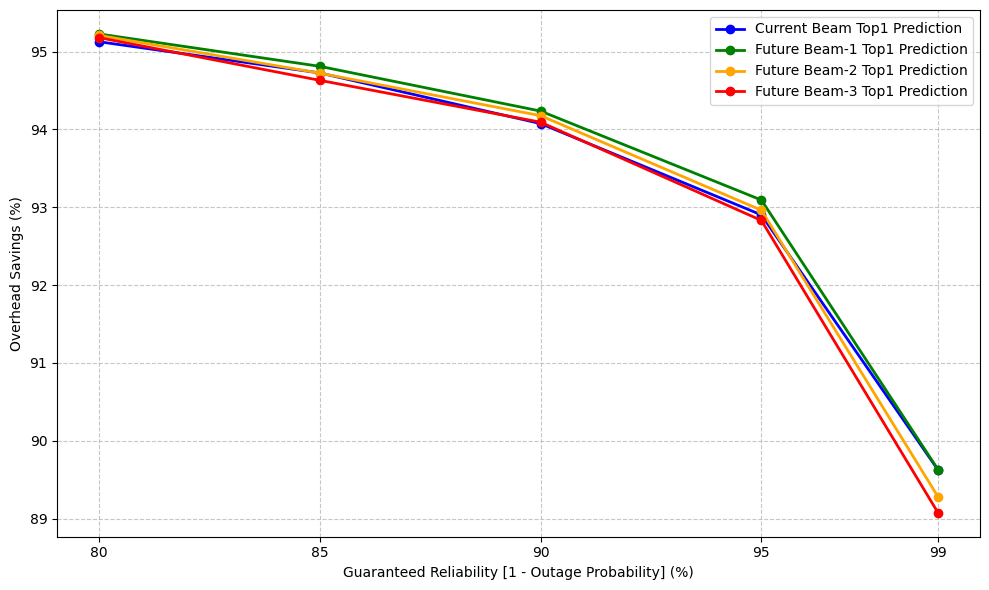

In [26]:
dataplot.plot_overhead_savings(df, folder_name=folder_path, format='pdf')

Saving plot to F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap/reliability_metrics.pdf


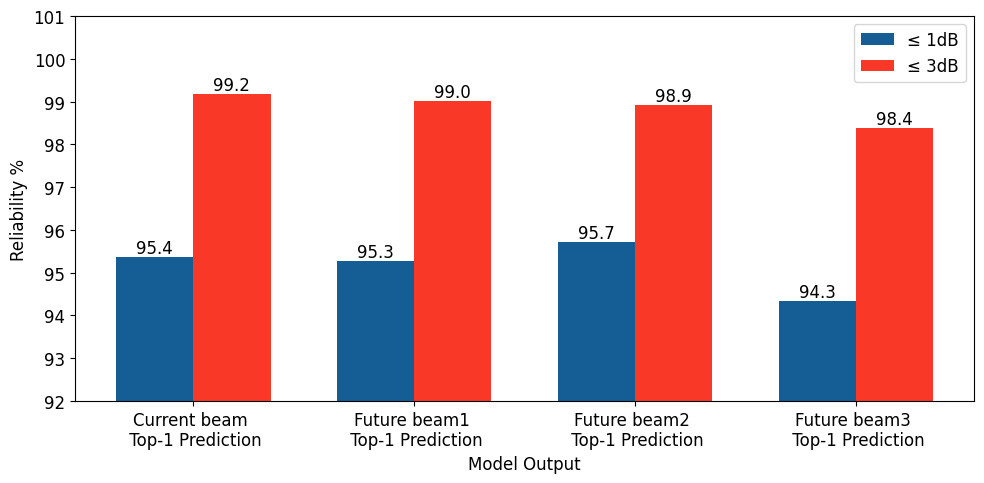

In [27]:
dataplot.plot_reliability_metrics(df, folder_path, format='pdf', y_max=101)

Saving overhead savings data to F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap/overhead_savings_data.csv
Saving reliability metrics data to F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap/reliability_metrics_data.csv
Saving combined plot data to F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap/combined_metrics_data.csv
Saving combined plot to F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap/combined_metrics_horizontal.pdf


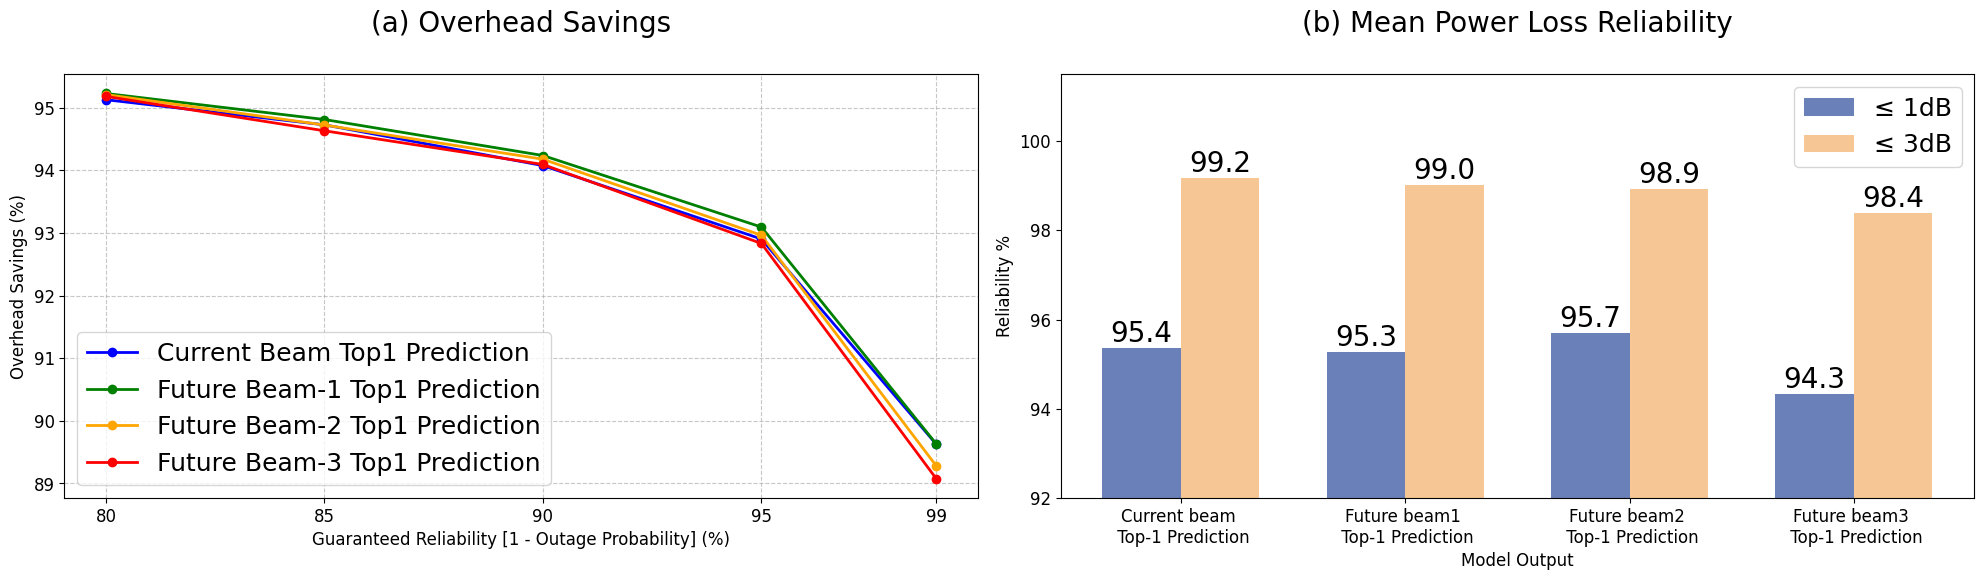

In [28]:
dataplot.plot_overhead_savings_and_reliability_metrics(df, folder_path, format='pdf', 
                                                       orientation='horizontal',
                                                       axis_fontsize=20,
                                                       bar_fontsize=20,
                                                       legend_fontsize=18,
                                                       y_max=101.5)

# Train & Val Loss VS Epoch

In [29]:
fname_epoch = r'F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\05-20-2025_15_10_42\dl_generated\model_measurement\train_val_epoch_vs_loss.csv'
model_measurement_dir = '\\'.join(fname_epoch.split('\\')[:-1])
epoch_df = pd.read_csv(fname_epoch)
epoch_df

dataplot.plot_loss_vs_epochs(df=epoch_df,
                            folder_name=model_measurement_dir,
                            fontsize=18,
                            axis_fontsize=18,
                            tick_fontsize=18,
                            legend_fontsize=14)





Saved plot to F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\05-20-2025_15_10_42\dl_generated\model_measurement/train_val_loss_vs_epochs.pdf


# 

# Table Baseline Comparison

In [30]:
# use test recap
fname_base_pred = r'F:\repo\gpsbeam\data\experiment_result\00_test_drone_base_prediction_20052025_145114\model_recap\exp_test_result_recap.csv'
fname_base_track = r'F:\repo\gpsbeam\data\experiment_result\00_test_drone_base_tracking_20052025_145517\model_recap\exp_test_result_recap.csv'
fname_proposed = r'F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap\exp_test_result_recap.csv'

df_base_pred = pd.read_csv(fname_base_pred)
df_base_track = pd.read_csv(fname_base_track)
df_proposed = pd.read_csv(fname_proposed)

df_base_pred['model_arch_name'] = 'Baseline Prediction'
df_base_track['model_arch_name'] = 'Baseline Tracking'
df_proposed['model_arch_name'] = 'Proposed'
df_compare = pd.concat([df_base_pred, df_base_track, df_proposed])

# Move model_arch_name column to first position
cols = df_compare.columns.tolist()
cols.remove('model_arch_name')
cols = ['model_arch_name'] + cols
df_compare = df_compare[cols]

selected_cols = ['model_arch_name', 'model_input_column_list', 'model_size_MiB'] + \
                [f'pred{i}_top{j}_test_acc_percent' for i in range(4) for j in [1,3,5]] +\
                [f'pred{i}_top1_mean_power_loss_db' for i in range(4)]

df_compare['model_input_column_list'] = df_compare['model_input_column_list'].apply(lambda x: [str(replace_dict[i]) if i in replace_dict else i for i in ast.literal_eval(x)])

df_compare = df_compare[selected_cols]
df_compare.reindex()
folder_path = '\\'.join(fname_proposed.split('\\')[:-1])
# folder_path = '/'.join(fname_proposed.split('/')[:-1])
saved_path = folder_path + '/baseline_comparison.csv'
print(f'saved_path: {saved_path}')
df_compare.to_csv(saved_path, index=False)

df_compare



saved_path: F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap/baseline_comparison.csv


,model_arch_name,model_input_column_list,model_size_MiB,pred0_top1_test_acc_percent,pred0_top3_test_acc_percent,pred0_top5_test_acc_percent,pred1_top1_test_acc_percent,pred1_top3_test_acc_percent,pred1_top5_test_acc_percent,pred2_top1_test_acc_percent,pred2_top3_test_acc_percent,pred2_top5_test_acc_percent,pred3_top1_test_acc_percent,pred3_top3_test_acc_percent,pred3_top5_test_acc_percent,pred0_top1_mean_power_loss_db,pred1_top1_mean_power_loss_db,pred2_top1_mean_power_loss_db,pred3_top1_mean_power_loss_db
0,Baseline Prediction,[ue_normalized_lat_lon],1.07,60.0,87.5,96.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.822,NaN,NaN,NaN
0,Baseline Tracking,[ue_normalized_lat_lon],0.59,NaN,NaN,NaN,63.9,88.7,96.8,63.9,89.9,96.2,63.2,89.6,95.6,NaN,0.905,1.068,1.348
0,Proposed,"[ue_normalized_lat_lon, ue_bs_vector]",0.99,76.1,97.3,98.8,75.3,97.8,99.3,73.2,97.4,99.1,70.9,95.3,98.2,0.299,0.278,0.272,0.567


In [31]:
def format_baseline_comparison_table(df_compare):
    """
    Format baseline comparison table with multi-level columns.
    
    Args:
        df_compare (pd.DataFrame): Input dataframe with baseline comparison data
        
    Returns:
        pd.DataFrame: Formatted dataframe with multi-level columns
    """
    # Create MultiIndex columns
    columns = pd.MultiIndex.from_tuples([
        ('Model Type', '', ''),
        ('Input','',''),
        ('Size', '', 'MB'),
        ('Current Beam Prediction', 'Top-1 Acc.', '%'),
        ('Current Beam Prediction', 'Top-3 Acc.', '%'), 
        ('Current Beam Prediction', 'Top-1 Mean Power Loss', 'dB'),
        ('Future Beam 1 Prediction', 'Top-1 Acc.', '%'),
        ('Future Beam 1 Prediction', 'Top-3 Acc.', '%'),
        ('Future Beam 1 Prediction', 'Top-1 Mean Power Loss', 'dB'),
        ('Future Beam 2 Prediction', 'Top-1 Acc.', '%'),
        ('Future Beam 2 Prediction', 'Top-3 Acc.', '%'),
        ('Future Beam 2 Prediction', 'Top-1 Mean Power Loss', 'dB'),
        ('Future Beam 3 Prediction', 'Top-1 Acc.', '%'),
        ('Future Beam 3 Prediction', 'Top-3 Acc.', '%'),
        ('Future Beam 3 Prediction', 'Top-1 Mean Power Loss', 'dB')
    ])

    # Create formatted dataframe
    df_formatted = df_compare.copy()
    
    # Rearrange columns in desired order
    df_formatted = df_formatted[['model_arch_name', 'model_input_column_list', 'model_size_MiB',
                               'pred0_top1_test_acc_percent', 'pred0_top3_test_acc_percent', 'pred0_top1_mean_power_loss_db',
                               'pred1_top1_test_acc_percent', 'pred1_top3_test_acc_percent', 'pred1_top1_mean_power_loss_db', 
                               'pred2_top1_test_acc_percent', 'pred2_top3_test_acc_percent', 'pred2_top1_mean_power_loss_db',
                               'pred3_top1_test_acc_percent', 'pred3_top3_test_acc_percent', 'pred3_top1_mean_power_loss_db']]

    df_formatted.columns = columns
    
    return df_formatted

# Format table and save
df_formatted = format_baseline_comparison_table(df_compare)

folder_path = '\\'.join(fname_proposed.split('\\')[:-1])
# folder_path = '/'.join(fname_proposed.split('/')[:-1])
saved_path = folder_path + '\\baseline_comparison_formatted.csv'
# saved_path = folder_path + '/baseline_comparison_formatted.csv'
print(f'saved_path: {saved_path}')
df_formatted.to_csv(saved_path, index=False)

# Display formatted table
df_formatted


saved_path: F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap\baseline_comparison_formatted.csv


Model Type                                  Input  Size  \
                                                                      
                                                                 MB   
0  Baseline Prediction                [ue_normalized_lat_lon]  1.07   
0    Baseline Tracking                [ue_normalized_lat_lon]  0.59   
0             Proposed  [ue_normalized_lat_lon, ue_bs_vector]  0.99   

  Current Beam Prediction                                   \
               Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss   
                        %          %                    dB   
0                    60.0       87.5                 0.822   
0                     NaN        NaN                   NaN   
0                    76.1       97.3                 0.299   

  Future Beam 1 Prediction                                   \
                Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss   
                         %          %                    dB   
0                      NaN        NaN                   NaN   
0                     63.9       88.7                 0.905   
0                     75.3       97.8                 0.278   

  Future Beam 2 Prediction                                   \
                Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss   
                         %          %                    dB   
0                      NaN        NaN                   NaN   
0                     63.9       89.9                 1.068   
0                     73.2       97.4                 0.272   

  Future Beam 3 Prediction                                   
                Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss  
                         %          %                    dB  
0                      NaN        NaN                   NaN  
0                     63.2       89.6                 1.348  
0                     70.9       95.3                 0.567

# Baseline Comparison with Feature Variation

In [32]:
fname = r'F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_feature_input_20052025_152755\model_recap\exp_test_result_recap.csv'
df = pd.read_csv(fname)
# df = df_apply_combined_metric(df)
df['model_input_column_list'] = df['model_input_column_list'].apply(lambda x: [str(replace_dict[i]) if i in replace_dict else i for i in ast.literal_eval(x)])
df['model_input_column_list'] = df['model_input_column_list'].astype(str)
# remove ['unit1_beam_idx_32'] on col model_input_column_list
df = df[df['model_input_column_list'] != "['unit1_beam_idx_32']"]
# Add model_arch_name column filled with "Proposed"
df['model_arch_name'] = 'Proposed'

df_feature_variation_formatted = format_baseline_comparison_table(df)

df_feature_variation_formatted

Model Type                                      Input  Size  \
                                                                
                                                           MB   
0   Proposed                  ['ue_normalized_lat_lon']  0.99   
1   Proposed                           ['ue_bs_vector']  0.99   
2   Proposed  ['ue_normalized_lat_lon', 'ue_bs_vector']  0.99   

  Current Beam Prediction                                   \
               Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss   
                        %          %                    dB   
0                    64.8       89.8                 0.726   
1                    65.6       92.8                 1.471   
2                    76.1       97.3                 0.299   

  Future Beam 1 Prediction                                   \
                Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss   
                         %          %                    dB   
0                     63.7       90.3                 0.805   
1                     65.3       94.5                 1.365   
2                     75.3       97.8                 0.278   

  Future Beam 2 Prediction                                   \
                Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss   
                         %          %                    dB   
0                     63.4       89.7                 0.889   
1                     64.9       94.6                 1.301   
2                     73.2       97.4                 0.272   

  Future Beam 3 Prediction                                   
                Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss  
                         %          %                    dB  
0                     62.5       88.2                 1.224  
1                     63.5       93.5                 1.538  
2                     70.9       95.3                 0.567

In [33]:
df_feature_baseline_formatted = pd.concat([df_formatted, df_feature_variation_formatted])
df_feature_baseline_formatted.reset_index(drop=True, inplace=True)
# Move row 2 to last and remove last row (because it has same model_arch_name and model input)
df_feature_baseline_formatted = pd.concat([df_feature_baseline_formatted.iloc[[0,1]], df_feature_baseline_formatted.iloc[3:-1], df_feature_baseline_formatted.iloc[[2]]])
df_feature_baseline_formatted.reset_index(drop=True, inplace=True)

saved_path = folder_path + '\\baseline_comparison_feature_variation_formatted.csv'
print(f'saved_path: {saved_path}')
df_feature_baseline_formatted.to_csv(saved_path, index=False)

df_feature_baseline_formatted

saved_path: F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151021\model_recap\baseline_comparison_feature_variation_formatted.csv


Model Type                                  Input  Size  \
                                                                      
                                                                 MB   
0  Baseline Prediction                [ue_normalized_lat_lon]  1.07   
1    Baseline Tracking                [ue_normalized_lat_lon]  0.59   
2             Proposed              ['ue_normalized_lat_lon']  0.99   
3             Proposed                       ['ue_bs_vector']  0.99   
4             Proposed  [ue_normalized_lat_lon, ue_bs_vector]  0.99   

  Current Beam Prediction                                   \
               Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss   
                        %          %                    dB   
0                    60.0       87.5                 0.822   
1                     NaN        NaN                   NaN   
2                    64.8       89.8                 0.726   
3                    65.6       92.8                 1.471   
4                    76.1       97.3                 0.299   

  Future Beam 1 Prediction                                   \
                Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss   
                         %          %                    dB   
0                      NaN        NaN                   NaN   
1                     63.9       88.7                 0.905   
2                     63.7       90.3                 0.805   
3                     65.3       94.5                 1.365   
4                     75.3       97.8                 0.278   

  Future Beam 2 Prediction                                   \
                Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss   
                         %          %                    dB   
0                      NaN        NaN                   NaN   
1                     63.9       89.9                 1.068   
2                     63.4       89.7                 0.889   
3                     64.9       94.6                 1.301   
4                     73.2       97.4                 0.272   

  Future Beam 3 Prediction                                   
                Top-1 Acc. Top-3 Acc. Top-1 Mean Power Loss  
                         %          %                    dB  
0                      NaN        NaN                   NaN  
1                     63.2       89.6                 1.348  
2                     62.5       88.2                 1.224  
3                     63.5       93.5                 1.538  
4                     70.9       95.3                 0.567